# Importy

In [11]:
import os
import cv2
import numpy as np
import pickle
import joblib
import time
import psutil
import platform
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import optuna
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from skimage.feature import graycomatrix, graycoprops
from IPython.display import display, HTML
import warnings

warnings.filterwarnings("ignore")
display(HTML("<style>.output_scroll {height: 300px; overflow: auto;}</style>"))

# Informacje o sprzęcie

In [2]:
def print_hardware_info():
    print("\n--- SPRZĘT ---")

    # Informacje o systemie operacyjnym
    print("System:", platform.system(), platform.release())

    # Informacje o CPU
    print("Procesor:", platform.processor() or "Brak szczegółów (platform.processor())")
    print("Liczba rdzeni fizycznych:", psutil.cpu_count(logical=False))
    print("Liczba rdzeni logicznych (wątki):", psutil.cpu_count(logical=True))
    try:
        cpu_freq = psutil.cpu_freq()
        if cpu_freq:
            print(f"Częstotliwość CPU: {cpu_freq.current:.2f} MHz")
    except:
        pass

    # RAM
    ram_gb = psutil.virtual_memory().total / (1024 ** 3)
    print(f"RAM: {ram_gb:.2f} GB")

    # Informacje o GPU z TensorFlow
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        print(f"Liczba dostępnych GPU: {len(gpus)}")
        for i, gpu in enumerate(gpus):
            details = tf.config.experimental.get_device_details(gpu)
            name = details.get("device_name", "N/A")
            print(f"GPU {i+1}: {name}")
    else:
        print("GPU: brak (CPU only)")

print_hardware_info()


--- SPRZĘT ---
System: Linux 5.10.234-225.910.amzn2.x86_64
Procesor: x86_64
Liczba rdzeni fizycznych: 2
Liczba rdzeni logicznych (wątki): 4
Częstotliwość CPU: 2499.99 MHz
RAM: 15.43 GB
GPU: brak (CPU only)


2025-04-05 10:23:10.540611: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


# Ścieżki

In [3]:
TRAIN_DIR = "/home/studio-lab-user/sagemaker-studiolab-notebooks/ThesisProject/data/processed/plant_village_balanced/train"
TEST_DIR = "/home/studio-lab-user/sagemaker-studiolab-notebooks/ThesisProject/data/processed/plant_village_balanced/test"
FEATURES_CACHE = "cached_features_v2.pkl"
study_name = "svm_hyperopt_feature_v2"
storage_url = f"sqlite:///{study_name}.db"

# Ekstrakcja cech z obrazu

In [4]:
def extract_features(path):
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    features = []

    means = cv2.mean(img)[:3]
    stddev = cv2.meanStdDev(img)[1].flatten()[:3]
    features.extend(means)
    features.extend(stddev)

    hist = cv2.calcHist([hsv], [0], None, [16], [0, 180]).flatten()
    features.extend(hist)

    glcm = graycomatrix(gray, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
    for prop in ['contrast', 'correlation', 'homogeneity', 'ASM']:
        features.append(graycoprops(glcm, prop)[0][0])

    moments = cv2.moments(gray)
    hu = cv2.HuMoments(moments).flatten()
    features.extend(hu)

    entropy = -np.sum((gray / 255.0) * np.log2((gray / 255.0) + 1e-10)) / gray.size
    features.append(entropy)

    return features

# Ładowanie danych

In [5]:
def load_dataset_from_dir(data_dir):
    X, y = [], []
    class_names = sorted(os.listdir(data_dir))

    for class_name in tqdm(class_names, desc=f"Loading from {os.path.basename(data_dir)}"):
        class_path = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        for fname in os.listdir(class_path):
            if fname.lower().endswith((".jpg", ".jpeg", ".png")):
                fpath = os.path.join(class_path, fname)
                feats = extract_features(fpath)
                X.append(feats)
                y.append(class_name)

    return np.array(X), np.array(y)

# Wczytywanie lub generowanie cech

In [6]:
if os.path.exists(FEATURES_CACHE):
    print("\nWczytywanie cech z cache...")
    with open(FEATURES_CACHE, "rb") as f:
        X, y = pickle.load(f)
else:
    print("\nEkstrakcja cech, może chwilę potrwać...")
    X_train, y_train = load_dataset_from_dir(TRAIN_DIR)
    X_test, y_test = load_dataset_from_dir(TEST_DIR)
    X = np.concatenate((X_train, X_test), axis=0)
    y = np.concatenate((y_train, y_test), axis=0)
    with open(FEATURES_CACHE, "wb") as f:
        pickle.dump((X, y), f)
    print("Zapisano do cache.")


Wczytywanie cech z cache...


# Podział na dane treningowe i testowe oraz kodowanie etykiet

In [8]:
# Wczytanie danych z gotowych folderów
X_train, y_train = load_dataset_from_dir(TRAIN_DIR)
X_test, y_test = load_dataset_from_dir(TEST_DIR)

# Kodowanie etykiet
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

Loading from test: 100%|██████████| 39/39 [01:58<00:00,  3.03s/it]


# Wizualizacja liczności klas w zbiorach treningowym i testowym

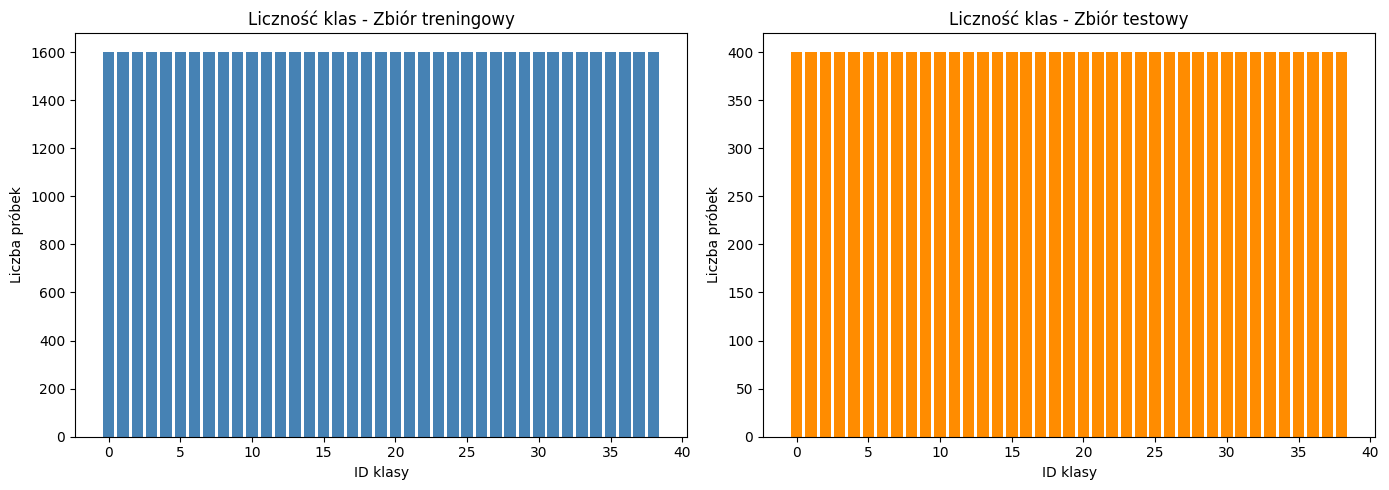

,ID klasy,Nazwa klasy
0,0,Apple___Apple_scab
1,1,Apple___Black_rot
2,2,Apple___Cedar_apple_rust
3,3,Apple___healthy
4,4,Background_without_leaves
5,5,Blueberry___healthy
6,6,Cherry___Powdery_mildew
7,7,Cherry___healthy
8,8,Corn___Cercospora_leaf_spot Gray_leaf_spot
9,9,Corn___Common_rust


In [17]:
# Mapowanie nazw klas na indeksy
class_labels = sorted(set(list(y_train) + list(y_test)))
label_to_index = {label: i for i, label in enumerate(class_labels)}

# Zliczanie klas z użyciem indeksów
train_counts = Counter([label_to_index[label] for label in y_train])
test_counts = Counter([label_to_index[label] for label in y_test])

# Wykres bez nazw klas (tylko indeksy)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(train_counts.keys(), train_counts.values(), color="steelblue")
axes[0].set_title("Liczność klas - Zbiór treningowy")
axes[0].set_xlabel("ID klasy")
axes[0].set_ylabel("Liczba próbek")

axes[1].bar(test_counts.keys(), test_counts.values(), color="darkorange")
axes[1].set_title("Liczność klas - Zbiór testowy")
axes[1].set_xlabel("ID klasy")
axes[1].set_ylabel("Liczba próbek")

plt.tight_layout()
plt.show()

# Wyświetlenie tabeli klas i ID (do czytania)
import pandas as pd
label_df = pd.DataFrame({
    "ID klasy": list(label_to_index.values()),
    "Nazwa klasy": list(label_to_index.keys())
}).sort_values("ID klasy")
display(label_df)

# Wczytanie najlepszego parametru C z Optuna

In [10]:
study = optuna.load_study(study_name=study_name, storage=storage_url)
best_C = study.best_trial.params['C']
print(f"Najlepsze C z Optuny: {best_C}")

Najlepsze C z Optuny: 175.28676604484232


# Trenowanie modelu SVM w pipeline

In [18]:
model = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(C=best_C, kernel="linear", gamma="scale", probability=False))
])

# Trening i pomiar czasu
start_time = time.time()
model.fit(X_train, y_train_enc)
training_time = time.time() - start_time

# Ewaluacja modelu SVM

In [19]:
# Predykcja na danych testowych
y_pred = model.predict(X_test)

# Ewaluacja klasyczna
accuracy = accuracy_score(y_test_enc, y_pred)
precision = precision_score(y_test_enc, y_pred, average='weighted')
recall = recall_score(y_test_enc, y_pred, average='weighted')
f1 = f1_score(y_test_enc, y_pred, average='weighted')
report = classification_report(y_test_enc, y_pred, target_names=label_encoder.classes_)

# Liczba support vectors (w SVMie to istotne jako pośredni wskaźnik złożoności)
svm_model = model.named_steps["svm"]
n_support_vectors = sum(svm_model.n_support_)

# Rozmiar modelu po zapisaniu
model_path = "/home/studio-lab-user/sagemaker-studiolab-notebooks/ThesisProject/models/svm_model_v2.joblib"
os.makedirs(os.path.dirname(model_path), exist_ok=True)
joblib.dump(model, model_path)
model_size_kb = os.path.getsize(model_path) / 1024

# Wyświetlenie klasyfikacji
print(f"\n--- Ewaluacja modelu SVM ---")
print(f"Czas treningu: {training_time:.2f} sekundy")
print(f"Liczba support vectors: {n_support_vectors}")
print(f"Rozmiar modelu: {model_size_kb:.2f} KB")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1-score (weighted): {f1:.4f}")
print("\nPełny raport klasyfikacji:")
print(report)

# Tabela porównawcza metryk – do eksportu lub dalszego zestawienia
metrics_df = pd.DataFrame({
    "Model": ["SVM (linear)"],
    "C": [svm_model.C],
    "Training time [s]": [training_time],
    "Accuracy": [accuracy],
    "Precision": [precision],
    "Recall": [recall],
    "F1-score": [f1],
    "Support Vectors": [n_support_vectors],
    "Model Size [KB]": [model_size_kb]
})

display(metrics_df)


--- Ewaluacja modelu SVM ---
Czas treningu: 606.71 sekundy
Liczba support vectors: 23641
Rozmiar modelu: 20429.73 KB
Accuracy: 0.8479
Precision (weighted): 0.8486
Recall (weighted): 0.8479
F1-score (weighted): 0.8477

Pełny raport klasyfikacji:
                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.68      0.84      0.75       400
                            Apple___Black_rot       0.89      0.90      0.89       400
                     Apple___Cedar_apple_rust       0.77      0.85      0.81       400
                              Apple___healthy       0.83      0.85      0.84       400
                    Background_without_leaves       0.94      0.95      0.95       400
                          Blueberry___healthy       0.93      0.95      0.94       400
                      Cherry___Powdery_mildew       0.78      0.72      0.75       400
                             Cherry___healthy       0.93 

,Model,C,Training time [s],Accuracy,Precision,Recall,F1-score,Support Vectors,Model Size [KB]
0,SVM (linear),175.286766,606.70524,0.847949,0.848637,0.847949,0.847684,23641,20429.731445


# Zapis wyników

In [20]:
metrics_df.to_csv("/home/studio-lab-user/sagemaker-studiolab-notebooks/ThesisProject/reports/Results/svm_results.csv", index=False)

OSError: Cannot save file into a non-existent directory: 'sagemaker-studiolab-notebooks/ThesisProject/reports/Results'